Evaluating SBERT Hybrid: 100%|██████████| 3735/3735 [00:05<00:00, 657.87it/s]


Evaluated on 3735 items with ground truth.
Precision@10: 0.0485
Recall@10:    0.2147
NDCG@10:      0.2411


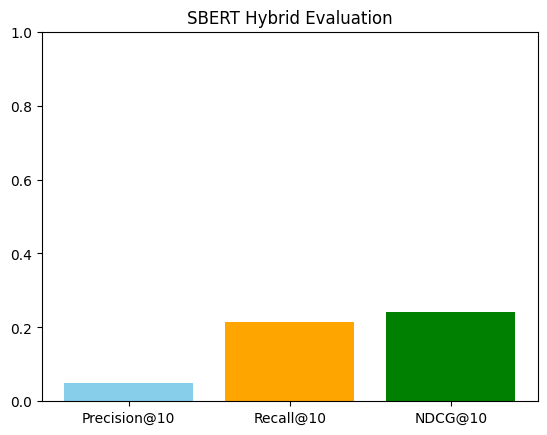

In [2]:
import pickle, re, ast, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

with open(r"C:\Users\yashw\PycharmProjects\PythonProject4\models\sbert_recommender.pkl", "rb") as f:
    cache = pickle.load(f)

df = cache["df"]
embeddings = cache["embeddings"]
tag_sims = cache["tag_sims"]
diff_sims = cache["diff_sims"]
popularity_score = cache["popularity_score"]

def clean_title(text):
    text = str(text).lower().strip()
    text = re.sub(r'^\d+\.\s*', '', text)
    text = re.sub(r'[^a-z0-9\s\-]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def parse_similar(x):
    try:
        if isinstance(x, str):
            lst = ast.literal_eval(x)
            return [clean_title(i) for i in lst]
        return []
    except Exception:
        return []

df['ground_truth'] = df['similar_questions'].apply(parse_similar)

def precision_recall_at_k(pred, truth, k=10):
    if not truth: return None, None
    pred_k = pred[:k]
    hits = len(set(pred_k) & set(truth))
    return hits / len(pred_k), hits / len(truth)

def ndcg_at_k(pred, truth, k=10):
    rel = [1 if item in truth else 0 for item in pred[:k]]
    if not any(rel): return 0.0
    dcg = sum(r / np.log2(i + 2) for i, r in enumerate(rel))
    idcg = sum(sorted(rel, reverse=True)[i] / np.log2(i + 2) for i in range(len(rel)))
    return dcg / idcg

def hybrid_scores(i, w_sim=0.70, w_tag=0.15, w_diff=0.10, w_pop=0.05):
    sims = embeddings @ embeddings[i]
    score = (
        w_sim * sims +
        w_tag * tag_sims[i] +
        w_diff * diff_sims[i] +
        w_pop * popularity_score
    )
    mn, mx = score.min(), score.max()
    if mx > mn:
        score = (score - mn) / (mx - mn)
    return score

def rank_by_scores(scores, k=10, exclude=None):
    if exclude is not None: scores[exclude] = -1e9
    idxs = np.argpartition(scores, -k)[-k:]
    idxs = idxs[np.argsort(scores[idxs])][::-1]
    return idxs

def evaluate_variant(weights=(0.70, 0.15, 0.10, 0.05), k=10):
    precisions, recalls, ndcgs = [], [], []
    for i in tqdm(range(len(df)), desc="Evaluating SBERT Hybrid"):
        gt = df.loc[i, 'ground_truth']
        if not gt: continue
        s = hybrid_scores(i, *weights)
        idxs = rank_by_scores(s.copy(), k=k, exclude=i)
        preds = [clean_title(df.iloc[j]['title']) for j in idxs]
        p, r = precision_recall_at_k(preds, gt, k)
        n = ndcg_at_k(preds, gt, k)
        if p is not None:
            precisions.append(p)
            recalls.append(r)
            ndcgs.append(n)
    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs), len(precisions)

prec, rec, ndcg, count = evaluate_variant()
print(f"Evaluated on {count} items with ground truth.")
print(f"Precision@10: {prec:.4f}")
print(f"Recall@10:    {rec:.4f}")
print(f"NDCG@10:      {ndcg:.4f}")

plt.bar(['Precision@10', 'Recall@10', 'NDCG@10'], [prec, rec, ndcg], color=['skyblue', 'orange', 'green'])
plt.title("SBERT Hybrid Evaluation")
plt.ylim(0,1)
plt.show()